In [1]:
from osmnx import graph_from_xml

In [2]:
graph = graph_from_xml('D:/Understanding GIS/week 9/kaliningrad/kaliningrad-cp1252.xml')

In [3]:
from rtree.index import Index

idx = Index()
for id, data in list(graph.nodes(data=True)):
    idx.insert(id, (data['x'],data['y']))

In [4]:
print(idx.count(idx.bounds), len(graph.nodes))

2694 2694


In [5]:
from_point = (20.483322,54.692934)
to_point = (20.544863,54.723827)

from_node = list(idx.nearest(from_point, 1))[0]
to_node = list(idx.nearest(to_point, 1))[0]

print(graph.nodes()[from_node], graph.nodes()[to_node])

{'y': 54.6950447, 'x': 20.4841665} {'y': 54.7242909, 'x': 20.5442207}


In [6]:
from pyproj import Geod

def ellipsoidal_distance(node_a, node_b):

	point_a = graph.nodes(data=True)[node_a]
	point_b = graph.nodes(data=True)[node_b]

	return Geod(ellps='WGS84').inv(point_a['x'], point_a['y'], point_b['x'], point_b['y'])[2]

In [7]:
ellipsoidal_distance(from_node, to_node)

5057.901463541513

In [8]:
def heuristic(node_a, node_b):

	point_a = graph.nodes(data=True)[node_a]
	point_b = graph.nodes(data=True)[node_b]

	return Geod(ellps='WGS84').inv(point_a['x'], point_a['y'], point_b['x'], point_b['y'])[2]

In [9]:
def reconstruct_path(end_node, parent_node, parents):

	path = [end_node]
	node = parent_node

	while node is not None:

		path.append(node)
		node = parents[node]
	
	path.reverse()
	return path

In [10]:
from heapq import heappush, heappop
from sys import exit
from networkx import NodeNotFound, NetworkXNoPath

In [11]:
def astar_path(G, source, target, heuristic):
    if source not in G or target not in G:
        raise NodeNotFound(f"Either source ({source}) or target ({target}) is not in the graph")
    
    counter = 0
    queue = [(0, counter, source, 0, None)]
    distances = {}
    parents = {}
    
    while queue:
        # pop the next node, its network distance from the start, and its parent from the queue
        cur_node, cur_net_dist, cur_parent = heappop(queue)[2:]
        
        if cur_node == target:
            return reconstruct_path(cur_node, cur_parent, parents)
        
        if cur_node in parents:
            if parents[cur_node] is None:
                continue

            if distances[cur_node][0] < cur_net_dist:
                continue
                
        parents[cur_node] = cur_parent

        for neighbour, edge_data in G[cur_node].items():
            dist_from_start = cur_net_dist + edge_data[0]['length']
            
            if neighbour in distances:

                previous_dist_from_start, dist_to_end = distances[neighbour]

                if previous_dist_from_start <= dist_from_start:
                    continue

            else:
                dist_to_end = heuristic(neighbour, target)
                distances[neighbour] = (dist_from_start, dist_to_end)
                estimated_dist = dist_from_start + dist_to_end
                
                # increment counter and push to heap
                counter += 1
                heappush(queue, (estimated_dist, counter, neighbour, dist_from_start, cur_node))
        
    raise NetworkXNoPath(f"Node {target} not reachable from {source}")

In [12]:
graph[1465187402].items()

ItemsView(AdjacencyView({1465187403: {0: {'osmid': 133161928, 'highway': 'service', 'oneway': False, 'reversed': False, 'length': 52.616}}, 1877163899: {0: {'osmid': 133161933, 'highway': 'service', 'oneway': False, 'reversed': False, 'length': 11.745}}, 1465187410: {0: {'osmid': 133161933, 'highway': 'service', 'oneway': False, 'reversed': True, 'length': 36.543, 'geometry': <LINESTRING (20.484 54.695, 20.484 54.695, 20.484 54.695)>}}}))

In [13]:
shortest_path = astar_path(graph, from_node, to_node, ellipsoidal_distance)

In [14]:
from shapely.geometry import LineString

def path_to_linestring(start_point, path_list, end_point):
	"""
	Convert a shortest path to a LineString object
	"""
	# initialise the list with the start point
	line = [start_point]

	# loop through each node in the shortest path and load into list
	for n in path_list:

		# get the relevant node from the graph with lat lng data
		node = graph.nodes(data=True)[n]

		# load the lat lng data into the lineString
		line.append((node['x'], node['y']))

	# append end point to list
	line.append(end_point)

	# store as a LineString
	return LineString(line)

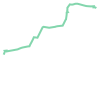

In [15]:
path_to_linestring((20.483322,54.692934), shortest_path, (20.544863,54.723827))

In [16]:
(graph.nodes(data=True)[shortest_path[0]]['x'],graph.nodes(data=True)[shortest_path[0]]['y'])

(20.4841665, 54.6950447)

In [17]:
from geopandas import GeoSeries

wgs84 = "+proj=longlat +datum=WGS84 +no_defs +type=crs"
utm34 = "+proj=utm +zone=34 +datum=WGS84 +units=m +no_defs +type=crs"
path = GeoSeries(path_to_linestring((20.483322,54.692934), shortest_path, (20.544863,54.723827)), crs=wgs84).to_crs(utm34)

In [18]:
from networkx import astar_path as astar_path_nx, DiGraph

shortest_path_nx = astar_path_nx(DiGraph(graph), from_node, to_node, ellipsoidal_distance)
path_nx = GeoSeries(path_to_linestring((20.483322,54.692934), shortest_path_nx, (20.544863,54.723827)), crs=wgs84).to_crs(utm34)

In [19]:
from geopandas import read_file
from shapely.geometry import Point
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.pyplot import subplots, savefig, Line2D

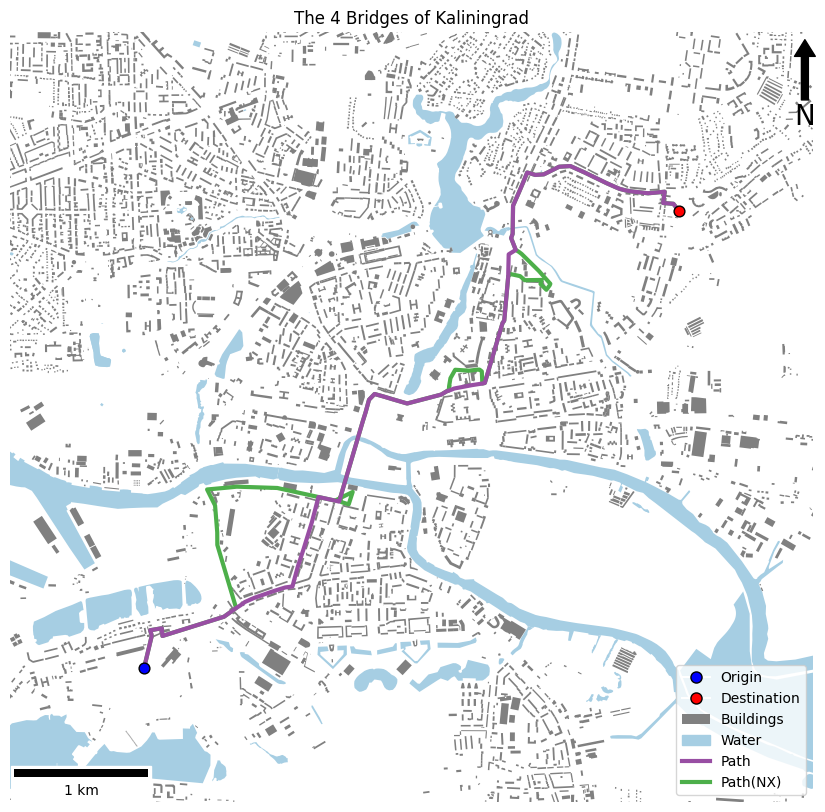

In [20]:
# open buildings and water shapefiles
buildings = read_file('D:/Understanding GIS/week 9/kaliningrad/buildings.shp').to_crs(utm34)
water = read_file('D:/Understanding GIS/week 9/kaliningrad/water.shp').to_crs(utm34)

# create map axis object, remove axes, set title
fig, my_ax = subplots(1, 1, figsize=(16, 10))
my_ax.axis('off')
my_ax.set(title="The 4 Bridges of Kaliningrad")

# set bounds
buffer = 1000
my_ax.set_xlim([path.geometry.iloc[0].bounds[0] - buffer, path.geometry.iloc[0].bounds[2] + buffer])
my_ax.set_ylim([path.geometry.iloc[0].bounds[1] - buffer, path.geometry.iloc[0].bounds[3] + buffer])

# add the water
water.plot(
	ax=my_ax,
	color='#a6cee3',
	linewidth = 1,
	zorder=1)

# add the buildings
buildings.plot(
	ax=my_ax,
	color='grey',
	linewidth = 1,
	zorder=2)

# add the path
path_nx.plot(
	ax=my_ax,
	color='#4daf4a',
	linewidth = 3,
	zorder=4)

path.plot(
	ax=my_ax,
	color='#984ea3',
	linewidth = 3,
	zorder=4)

# add the start point
GeoSeries(Point(from_point), crs=wgs84).to_crs(utm34).plot(
  ax = my_ax,
  markersize = 60,
  color = 'blue',
  edgecolor = 'black',
  zorder=5)

# add the end point
GeoSeries(Point(to_point), crs=wgs84).to_crs(utm34).plot(
  ax = my_ax,
  markersize = 60,
  color = 'red',
  edgecolor = 'black',
	zorder=6)

'''
for n in shortest_path:

    node = graph.nodes(data=True)[n]

    point = (node['x'], node['y'])
        
    GeoSeries(Point(point), crs=wgs84).to_crs(utm34).plot(
      ax = my_ax,
      markersize = 20,
      color = 'green',
      edgecolor = 'black',
        zorder=7)
'''

# manually draw a legend
my_ax.legend([
	Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', markersize=8),
	Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', markersize=8),
    Patch(facecolor='grey'),
    Patch(facecolor='#a6cee3', edgecolor='#a6cee3'),
	Line2D([0], [0], color='#984ea3', lw=3),
	Line2D([0], [0], color='#4daf4a', lw=3)],
	['Origin', 'Destination', 'Buildings', 'Water', 'Path', 'Path(NX)'], loc='lower right')

# add north arrow
x, y, arrow_length = 0.99, 0.99, 0.1
my_ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
	arrowprops=dict(facecolor='black', width=5, headwidth=15),
	ha='center', va='center', fontsize=20, xycoords=my_ax.transAxes)

# add scalebar
my_ax.add_artist(ScaleBar(dx=1, units="m", location="lower left"))